In [1]:
!pip install pykrev

     -------------------------------------- 119.9/119.9 kB 6.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### 공식문서 https://nbviewer.org/github/Kzra/pykrev/tree/master/docs/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pykrev as pk

In [2]:
A = pk.read_csv('data/pykrev_data/example_A.csv', column_headers = True) 
B  = pk.read_csv('data/pykrev_data/example_B.csv', column_headers = True)
C = pk.read_csv('data/pykrev_data/example_C.csv', column_headers = True)

In [3]:
elementCounts = pk.element_counts(A)
elementRatios = pk.element_ratios(A, ratios = ['HC','OH','OC'])
print(f'formula = {A.formula[0]}') #The first formula in the msTuple
print(f'element counts = {elementCounts[0]}') #the result is a list of len(A.formula) in which each item is a dictionary containing C,H,N,O,P,S counts
print(f'element ratios = {elementRatios[0]}') #the result is a list of len(A.formula) in which each item is a dictionary containing the ratios given in ratios 

formula = C6H6O2
element counts = {'C': 6, 'H': 6, 'N': 0, 'O': 2, 'P': 0, 'S': 0, 'Cl': 0, 'F': 0}
element ratios = {'HC': 1.0, 'OH': 0.3333333333333333, 'OC': 0.3333333333333333}


In [4]:
dbe = pk.double_bond_equivalent(A) # the result is a numpy.ndarray of len(A.formula)

In [7]:
ai = pk.aromaticity_index(A, index_type = 'rAI') # index_type can be reformulated or original, and account for a modified O coefficient.
nosc = pk.nominal_oxidation_state(A)

#### van_krevelen_plot

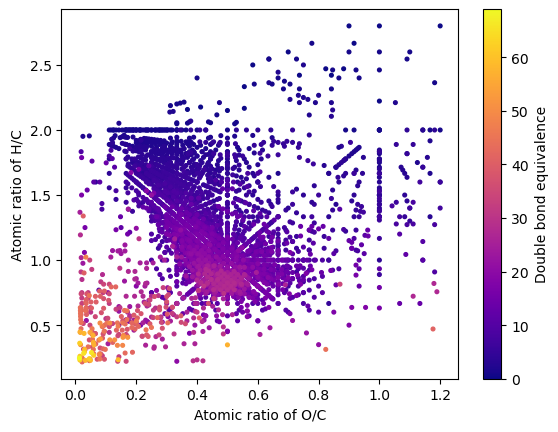

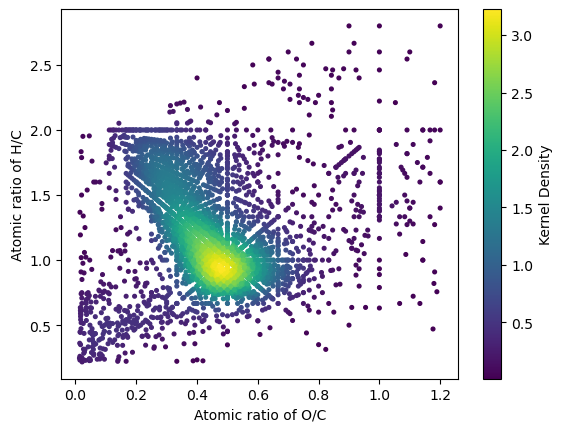

In [5]:
#Here we make a van Krevelen style plot where the y axis represents N/C values, and colour code the points by double bond equivalence 
plt.figure()
pk.van_krevelen_plot(A, y_ratio = 'HC',c = dbe,s = 7,cmap = 'plasma') #van_krevele_plot takes any keyword arguments that can be passed to pyplot.scatter() 
cbar = plt.colorbar() #add a colour bar 
cbar.set_label('Double bond equivalence')
plt.grid(False)
#PyKrev.van_krevelen_plot can take the value 'density' for the key word argument 'c' to colour code points based on kernel density
plt.figure()
pk.van_krevelen_plot(A ,c='density',s = 7)
plt.colorbar().set_label('Kernel Density')
plt.grid(False)

#### Kendrick mass defect plots 

(250.0, 1000.0)

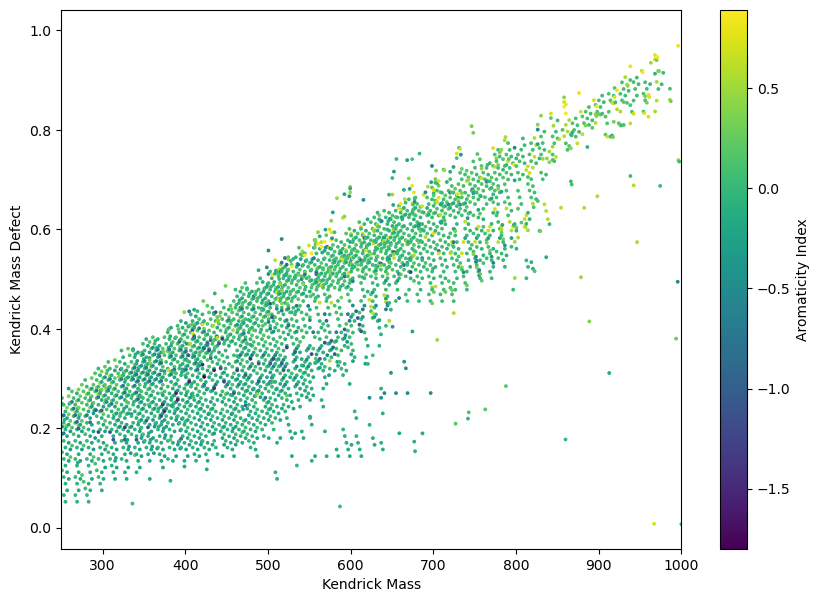

In [8]:
plt.figure(figsize = (10,7))
fig, ax ,(kendrickMass, kendrickMassDefect) = pk.kendrick_mass_defect_plot(A, base = 'CH2', rounding = 'ceil', s = 3, c = ai)
plt.colorbar().set_label('Aromaticity Index')
plt.xlim([250,1000])

#### Create a graphML representation of the reaction network which can be visualised using Cytoscape

In [21]:
dataset = pd.read_csv('data/pykrev_data\corems_output.csv')
msTuple = pk.read_corems(dataset)
intensityArray = msTuple.intensity

In [16]:
"""The reactions that can occur are defined below """
reactionDict = {
## decarboxylation
'decarboxylation': -pk.calculate_mass(['CO2']),
## methylation 
'methylation': pk.calculate_mass(['CH2']),
## demethylation 
'demethylation': -pk.calculate_mass(['CH2']),
## hydrogenation
'hydrogenation': pk.calculate_mass(['H2']),
## dehydrogenation
'dehydrogenation': -pk.calculate_mass(['H2']),
## hydration 
'hydration': pk.calculate_mass(['H2O']),
## dehydration 
'dehydration': -pk.calculate_mass(['H2O']),
# oxidation 
'oxidation': pk.calculate_mass(['O']),
# reduction
'reduction': -pk.calculate_mass(['O'])
}

##### We can run the page rank algorithm using the page_rank function in PyKrev.

In [18]:
r = pk.page_rank(msTuple, reactionDict = reactionDict, d = 0.9, tol = 0.01)

22 iterations to convergence.


In [23]:
G, reactionCounts = pk.reaction_network(msTuple, reactionDict = reactionDict, filePath = 'data/FTICRMS.graphML', fileFormat = 'graphml', nodeAnnotations = {"pageRank" : r, "peakIntensity" : intensityArray}, roundVal = 8)
print(reactionCounts)

Number of nodes in graph:
2775
Number of edges in graph
18031
{'decarboxylation': 1711, 'methylation': 2178, 'demethylation': 2178, 'hydrogenation': 2083, 'dehydrogenation': 2083, 'hydration': 1869, 'dehydration': 1869, 'oxidation': 2030, 'reduction': 2030}
